In [1]:
# Standard tools for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Tools specific for geospatial data analysis
from mpl_toolkits.basemap import Basemap
import shapely
from shapely.geometry import shape, mapping, Point, Polygon
import geopandas as gpd
import geojsonio
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

# Tools from the Python Standard Library
import sys
import os
import re

from IPython.display import display
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Data preparation

In [2]:
RESULTSDIR = '../results/'
DATADIR = '../data/'
!ls $RESULTSDIR

01-air_quality.h5      01-neighborhoods.h5    02-service_requests.h5
01-crime.h5            01-service_requests.h5


In [3]:
service_requests = pd.read_hdf(RESULTSDIR + '02-service_requests.h5')

In [4]:
service_requests.head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,STATUS,DATETIMECLOSED,coordinates,time_to_close,time_since_init,neighborhood
0,21090,2009-07-01 10:24:19,Phone or Email,Yard Trimmings - Food Pail Request,RECYCLING,CLOSED,2009-07-27 11:34:09,"(37.807708, -122.248339)",26.0,3084.0,Cleveland Heights
1,21091,2009-07-01 11:14:09,Phone or Email,City Services - Missed Recycling,RECYCLING,CLOSED,2009-07-03 11:10:08,"(37.809762, -122.259388)",1.0,3084.0,Lakewide
2,21092,2009-07-01 15:58:47,Phone or Email,Yard Trimmings Service Issue (Residential),RECYCLING,CLOSED,2009-07-27 11:33:58,"(37.755521, -122.175515)",25.0,3084.0,Webster
3,21093,2009-07-01 15:59:26,Phone or Email,Yard Trimmings - Cart Request,RECYCLING,CLOSED,2009-07-03 11:09:54,"(37.868229, -122.243706)",1.0,3084.0,Panoramic Hill
4,21094,2009-07-01 16:03:05,Phone or Email,Residential Recycling - Oil - Kit Request,RECYCLING,CLOSED,2009-07-03 14:30:07,"(37.835057, -122.212352)",1.0,3084.0,Merriwood


In [5]:
neighborhoods = gpd.read_file(DATADIR + 'neighborhoods/oakland_neighborhoods_clean.shp')

In [6]:
neighborhoods['gentrified'] = neighborhoods['gentrified'].astype(bool)

In [7]:
neighborhoods.head()

,name,center_lon,center_lat,gentrified,geometry
0,Acorn/ Acorn Industrial,-122.308714,37.802146,False,"POLYGON ((-122.280212520786 37.8025938890711, ..."
1,Adams Point,-122.254662,37.812118,True,"POLYGON ((-122.247844000895 37.810057515347, -..."
2,Allendale,-122.203566,37.787141,False,"POLYGON ((-122.196320300415 37.7863349418319, ..."
3,Arroyo Viejo,-122.178464,37.760061,False,"POLYGON ((-122.170503431087 37.759584556553, -..."
4,Bancroft Business/ Havenscourt,-122.184941,37.766929,False,"POLYGON ((-122.177112657994 37.7654884250132, ..."


### Remove non-grafitti entries

In [8]:
service_requests = service_requests[service_requests['REQCATEGORY'] == 'GRAFFITI']

In [9]:
service_requests.shape

(22073, 11)

We still have a good number of entries!

In [10]:
service_requests.head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,STATUS,DATETIMECLOSED,coordinates,time_to_close,time_since_init,neighborhood
247,771448,2017-11-04 14:26:34,SeeClickFix,Graffiti on Street Litter Container,GRAFFITI,CLOSED,2017-11-06 15:10:11,"(37.810894, -122.262289)",2.0,36.0,Lakewide
260,771470,2017-11-04 15:37:23,SeeClickFix,Graffiti on Street Litter Container,GRAFFITI,CLOSED,2017-11-06 15:13:32,"(37.808453, -122.255049)",1.0,36.0,Adams Point
264,598379,2015-08-12 17:50:30,SeeClickFix,"Graffiti on Street, Street Light, Traffic Signal,",GRAFFITI,CLOSED,2015-08-21 08:15:44,"(37.809606, -122.264643)",8.0,851.0,Downtown
265,598381,2015-08-12 17:50:33,SeeClickFix,"Graffiti on Street, Street Light, Traffic Signal,",GRAFFITI,CLOSED,2015-08-18 11:07:53,"(37.818641, -122.254157)",5.0,851.0,Oakland Ave/ Harrison St
268,598395,2015-08-12 18:10:22,SeeClickFix,"Graffiti on Street, Street Light, Traffic Signal,",GRAFFITI,CLOSED,2015-08-18 11:07:29,"(37.811275, -122.260508)",5.0,851.0,Adams Point


## 2. Visualize differences between gentrified and non-gentrified areas

In [11]:
# Load the module that the scripts are stored in
sys.path.append("../scripts")

# Import the module for getting coordinates
from oakplot import counts_in_neighborhood, neighborhood_heat_map

In [12]:
n_graffiti = service_requests.groupby('neighborhood')['REQUESTID'].count()
n_graffiti.name = 'N_GRAFFITI'

In [13]:
neighborhoods = neighborhoods.join(n_graffiti, on='name')

Let's come up with bar plots of 

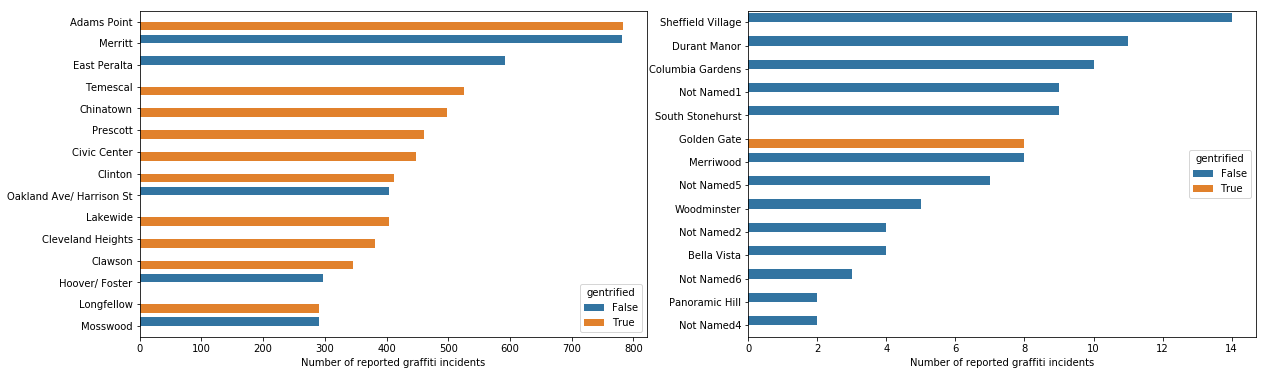

In [14]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
sns.barplot(x='N_GRAFFITI',
            y='name',
            data=neighborhoods.sort_values(by='N_GRAFFITI', ascending=False)[:15],
            hue='gentrified', ax=ax[0]);

sns.barplot(x='N_GRAFFITI',
            y='name',
            data=neighborhoods.sort_values(by='N_GRAFFITI', ascending=True)[:15][::-1],
            hue='gentrified', ax=ax[1]);

ax[0].set_xlabel('Number of reported graffiti incidents')
ax[1].set_xlabel('Number of reported graffiti incidents')
ax[0].set_ylabel('')
ax[1].set_ylabel('');

plt.savefig('../fig/03-graffiti_barplot.png')

From this, we can see that the areas with the highest number of graffiti reports seems to be split between gentrified and non-gentrified areas. But there are a few nuances to this:

1. Gentrification data for Merritt didn't exist in the dataset used. Considering that the neighbborhoods adjacent to it experienced gentrification, we can guess that it may in fact be gentrified too.
1. East Peralta is adjacent to Merritt.
1. [According to localwiki.org](https://localwiki.org/oakland/Harrison_St.-Oakland_Ave.), Oakland Ave/Harrison st. does in fact seem to be mostly occupied by young urban professionals (i.e., the gentrifiers).
1. [Also according to localwiki.org](https://localwiki.org/oakland/Hoover-Foster), the Hoover/Foster area "is rapidly filling with many artists and musicians as it's a short walk to the 19th street BART and a quick walk to the steadily growing Uptown nightlife scene."


One possible explanation here is the service request data we have is ahead of the gentrification data! This can in fact be tested used the timestamps on each request. Also, it's worth noting that so far we have not accounted for factors such as population. Nonetheless, based on these preliminary visualizations, it seems that there is some relationship between gentrification and reporting graffiti incidents.

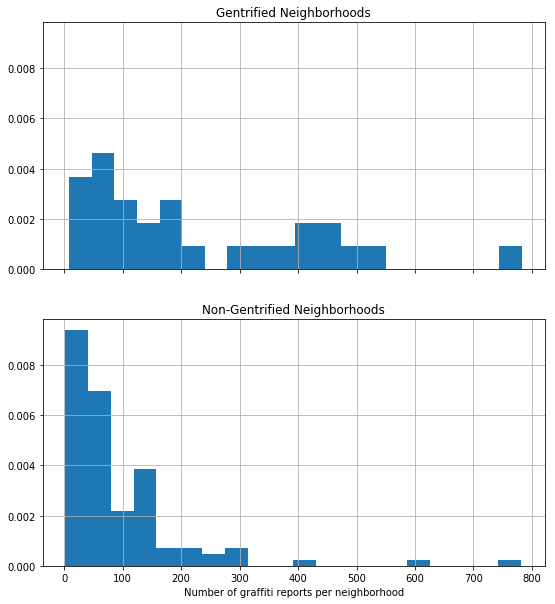

In [15]:
f, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(9, 10))

n_bins = 20
neighborhoods[neighborhoods['gentrified'] == True]['N_GRAFFITI'].hist(bins=n_bins, normed=True, ax=ax[0])
neighborhoods[neighborhoods['gentrified'] == False]['N_GRAFFITI'].hist(bins=n_bins, normed=True, ax=ax[1])
ax[1].set_xlabel('Number of graffiti reports per neighborhood')
ax[0].set_title('Gentrified Neighborhoods')
ax[1].set_title('Non-Gentrified Neighborhoods');
plt.savefig('../fig/03-hists.png')

In [16]:
from scipy.stats import ks_2samp

In [17]:
ks_2samp(neighborhoods[neighborhoods['gentrified'] == True]['N_GRAFFITI'],
         neighborhoods[neighborhoods['gentrified'] == False]['N_GRAFFITI'])

Ks_2sampResult(statistic=0.40629095674967236, pvalue=0.00081282075808405507)

### How are people reporting these?
Let's come up with a simple bar plot showing how these graffiti incidents are reported. The reason for doing this is that it may help us build a profile of who is making these reports. For example, I imagine that the younger generation is more likely to pull out their phone and submit a complaint on the website, as opposed to an older person who may first think to call the public works hotline.

In [18]:
sources = service_requests.groupby('SOURCE').count()['REQUESTID']
sources = sources.sort_values(ascending=False)

In [19]:
sources

SOURCE
SeeClickFix       13446
Phone or Email     4916
Website            1559
Email              1150
Phone               933
Voicemail            65
Other                 4
Name: REQUESTID, dtype: int64

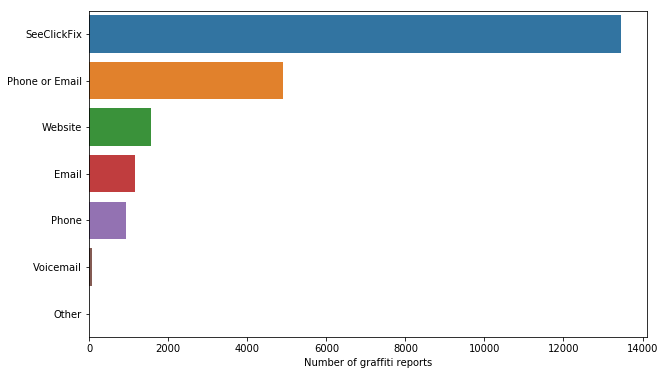

In [20]:
sns.barplot(x=sources.values,
            y=sources.index)

plt.xlabel('Number of graffiti reports')
plt.ylabel('');
plt.savefig('../fig/03-source_dist.png')

Most reports come via SeeClickFix, which is a service with a mobile app for reporting concerns. This tells us that most of the complaints people are making are coming from smartphones. While ubiquitous, I imagine that awareness of such an app would be primarily limited to younger people. If we go along this line of thinking, can we find any difference between how they are reported depending on the neighborhood?

In [21]:
seeclickfix = service_requests[service_requests['SOURCE'] == 'SeeClickFix']

In [22]:
# Count the number of graffiti incidents reported using SeeClickFix in each neighborhood
n_scf = seeclickfix.groupby('neighborhood')['REQUESTID'].count()
n_scf.name = 'N_SCF'

# Add this series to our neighborhoods DataFrame
neighborhoods = neighborhoods.join(n_scf, on='name')

# Get the fraction of graffiti reports that came from the app
neighborhoods['frac_SCF'] = neighborhoods['N_SCF'] / neighborhoods['N_GRAFFITI']

In [23]:
coords = {'llcrnrlat': 37.68944924029288,
          'llcrnrlon': -122.35304219896193,
          'urcrnrlat': 37.894234908415413,
          'urcrnrlon': -122.10048551341704}

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


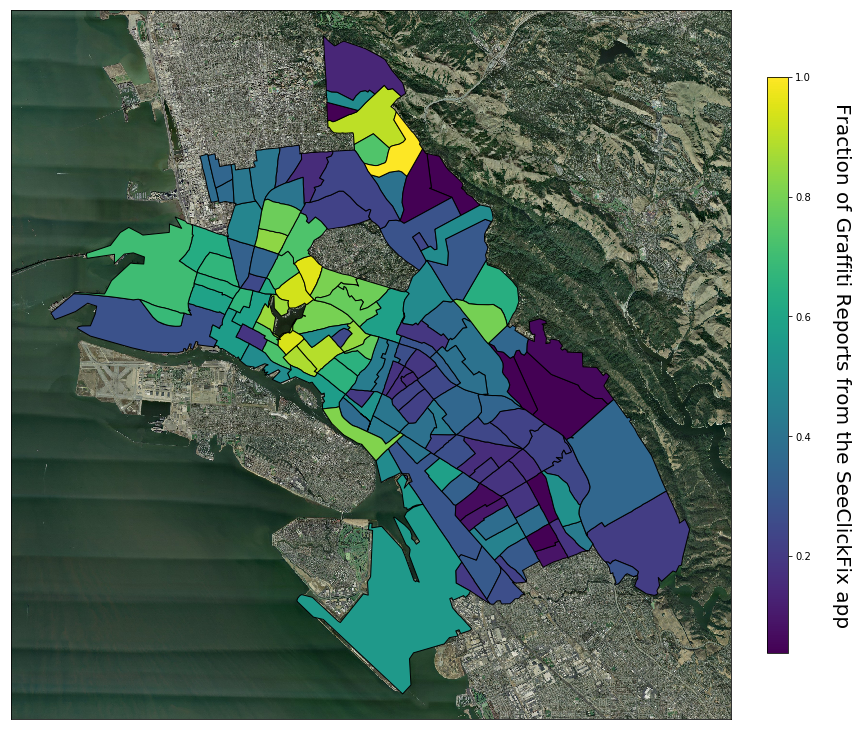

In [24]:
f, ax = neighborhood_heat_map(data=neighborhoods,
                              col='frac_SCF',
                              coords=coords,
                              label='Fraction of Graffiti Reports from the SeeClickFix app')

## Make a map of gentrified areas
- I'm primarily making this map here out of convenience.

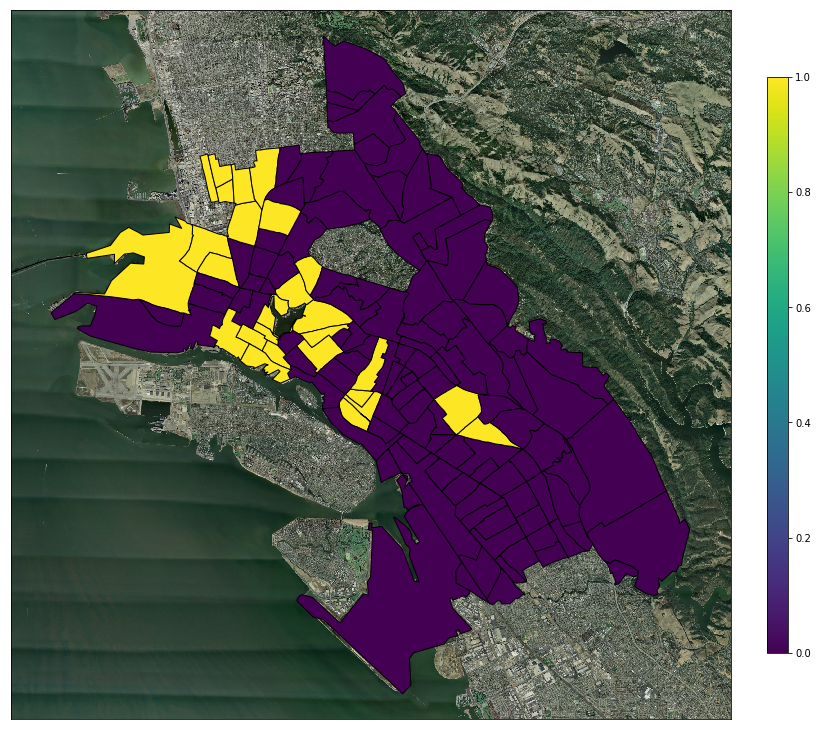

In [25]:
f, ax = neighborhood_heat_map(data=neighborhoods,
                              col='gentrified',
                              coords=coords,
                              label='')
plt.savefig('../fig/03-gentrification_map.png')